In [5]:
"""
Personality prediction from CV text - end-to-end pipeline demo.

Requirements (install before running):
pip install -U sentence-transformers scikit-learn xgboost shap pandas joblib

Usage:
- To try the demo, just run this script.
- To use a real dataset, prepare a CSV with columns:
    'text' (resume text), 'openness', 'conscientiousness', 'extraversion', 'agreeableness', 'emotional_stability'
  trait columns should be numeric (e.g., 1-5 or 0-1 floats). Then set DATA_CSV to your path.
"""

import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import joblib

# embedding
from sentence_transformers import SentenceTransformer

# explainability
import shap
import warnings
warnings.filterwarnings("ignore")

# -------------------------
# CONFIG
# -------------------------
# Replace with your dataset path if available
DATA_CSV = None  # Example: "data/resume_personality.csv"
MODEL_OUT = "cv_personality_model.joblib"
EMBEDDER_MODEL = "all-MiniLM-L6-v2"  # small & fast; swap for larger if resources exist

# -------------------------
# demo synthetic data generator (only used if DATA_CSV is None)
# -------------------------
def make_synthetic_dataset(n=200, seed=42):
    random.seed(seed)
    np.random.seed(seed)
    rows = []
    sample_resumes = [
        "Experienced software engineer with full-stack web development, led teams and shipped products.",
        "Creative designer focused on brand identity, illustration, and collaborative projects.",
        "Sales professional with extensive client-facing experience and strong negotiation skills.",
        "Research scientist with publications, data analysis, and rigorous experimental methods.",
        "Project manager experienced in cross-functional leadership and stakeholder communication."
    ]
    for i in range(n):
        text = " ".join(random.choices(sample_resumes, k=random.randint(1,3)))
        # synthetic trait signals (toy; real labels must come from assessments)
        openness = np.clip(np.random.normal(3 + ("Creative" in text)*0.8, 0.6), 1, 5)
        conscientiousness = np.clip(np.random.normal(3 + ("experienced" in text.lower())*0.6, 0.6), 1, 5)
        extraversion = np.clip(np.random.normal(3 + ("Sales" in text)*0.9, 0.8), 1, 5)
        agreeableness = np.clip(np.random.normal(3 + ("collaborative" in text)*0.6, 0.6), 1, 5)
        emotional_stability = np.clip(np.random.normal(3 + ("rigorous" in text or "research" in text)*0.4, 0.6), 1, 5)
        rows.append({
            "text": text,
            "openness": openness,
            "conscientiousness": conscientiousness,
            "extraversion": extraversion,
            "agreeableness": agreeableness,
            "emotional_stability": emotional_stability
        })
    return pd.DataFrame(rows)

# -------------------------
# Load data
# -------------------------
if DATA_CSV and os.path.exists(DATA_CSV):
    df = pd.read_csv(DATA_CSV)
    expected_cols = {"text","openness","conscientiousness","extraversion","agreeableness","emotional_stability"}
    if not expected_cols.issubset(set(df.columns)):
        raise ValueError(f"Dataset must contain columns: {expected_cols}")
else:
    print("DATA_CSV not provided or missing — using synthetic demo dataset.")
    df = make_synthetic_dataset(300)

print("Dataset shape:", df.shape)
print("Sample row:")
print(df.iloc[0].to_dict())

# -------------------------
# Preprocessing - minimal for resumes
# -------------------------
def preprocess_text(s):
    # keep simple: lowercasing, remove excessive whitespace. For production, consider:
    # - preserving bullets / section headers
    # - extracting sections (skills, experience, education)
    s = str(s).strip()
    s = " ".join(s.split())
    return s

df['text_clean'] = df['text'].map(preprocess_text)

# -------------------------
# Embedding using sentence-transformers
# -------------------------
print("Loading embedder:", EMBEDDER_MODEL)
embedder = SentenceTransformer(EMBEDDER_MODEL)

# embed all resumes (batch)
texts = df['text_clean'].tolist()
embeddings = embedder.encode(texts, show_progress_bar=True, batch_size=32)
X = np.array(embeddings)
y = df[["openness","conscientiousness","extraversion","agreeableness","emotional_stability"]].values

# -------------------------
# Train/test split
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.18, random_state=42)
print("Train/test sizes:", X_train.shape[0], X_test.shape[0])

# -------------------------
# Multi-output regression model (per-trait regressors)
# -------------------------
# Option A: simple linear model per trait (Ridge). Option B: RandomForest per trait.
# We'll train a Ridge for speed and demonstrate a RandomForest alternative.
models = {}
preds_test = np.zeros_like(y_test)

for i, trait in enumerate(["openness","conscientiousness","extraversion","agreeableness","emotional_stability"]):
    print(f"Training model for trait: {trait}")
    # try Ridge
    r = Ridge(alpha=1.0)
    r.fit(X_train, y_train[:, i])
    models[trait] = r
    preds_test[:, i] = r.predict(X_test)

# Evaluate
def evaluate(y_true, y_pred, trait_names):
    results = {}
    for i, t in enumerate(trait_names):
        mae = mean_absolute_error(y_true[:,i], y_pred[:,i])
        rmse = mean_squared_error(y_true[:,i], y_pred[:,i])
        r2 = r2_score(y_true[:,i], y_pred[:,i])
        results[t] = {"MAE": float(mae), "RMSE": float(rmse), "R2": float(r2)}
    return results

trait_names = ["openness","conscientiousness","extraversion","agreeableness","emotional_stability"]
eval_results = evaluate(y_test, preds_test, trait_names)
print("Evaluation on test set:")
for t,metrics in eval_results.items():
    print(t, metrics)

# -------------------------
# Save model and embedder
# -------------------------
joblib.dump({"models":models, "embedder_name": EMBEDDER_MODEL}, MODEL_OUT)
print("Saved model bundle to", MODEL_OUT)

# -------------------------
# Explainability demo (SHAP) for one trait (extraversion)
# -------------------------
# We'll fit a small tree-based model for SHAP demonstration (because SHAP works faster with tree explainer)
from sklearn.ensemble import RandomForestRegressor
print("Fitting a RandomForest for SHAP explanation on 'extraversion' (demo only)...")
rf = RandomForestRegressor(n_estimators=50, random_state=42)
rf.fit(X_train, y_train[:,2])
explainer = shap.Explainer(rf.predict, X_train)  # Kernel/Tree explainer depending on model
shap_values = explainer(X_test[:5], max_evals=765)  # compute for first 5 examples
print("Computed SHAP values for 5 examples (extraversion demo).")
# You can use shap.plots.waterfall or summary_plot in notebooks to visualize.

# -------------------------
# Function to apply model to a single resume text
# -------------------------
def predict_resume(text, model_bundle_path=MODEL_OUT):
    bundle = joblib.load(model_bundle_path)
    models = bundle["models"]
    embedder_name = bundle.get("embedder_name", EMBEDDER_MODEL)
    # If you want to reload the embedder by name:
    emb = SentenceTransformer(embedder_name)
    text_clean = preprocess_text(text)
    vec = emb.encode([text_clean])
    out = {}
    for trait, mdl in models.items():
        score = float(mdl.predict(vec)[0])
        # clamp to expected range 1-5
        out[trait] = max(1.0, min(5.0, score))
    return out

# -------------------------
# Demo apply on a sample resume
# -------------------------
sample_resume = """
John Doe
Full stack developer with 6 years experience building web applications.
Led a team of 5 engineers. Strong in Python, React, cloud deployments and mentoring junior engineers.
Published a blog about software design and contributed to open-source projects.
"""
print("Predicting on a sample resume...")
pred = predict_resume(sample_resume)
print("Predicted trait scores (1-5):")
print(pred)

# End of script

DATA_CSV not provided or missing — using synthetic demo dataset.
Dataset shape: (300, 6)
Sample row:
{'text': 'Experienced software engineer with full-stack web development, led teams and shipped products. Research scientist with publications, data analysis, and rigorous experimental methods. Creative designer focused on brand identity, illustration, and collaborative projects.', 'openness': 4.09802849180674, 'conscientiousness': 3.517041419297289, 'extraversion': 3.518150830480554, 'agreeableness': 4.513817913844815, 'emotional_stability': 3.2595079751659983}
Loading embedder: all-MiniLM-L6-v2


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Train/test sizes: 246 54
Training model for trait: openness
Training model for trait: conscientiousness
Training model for trait: extraversion
Training model for trait: agreeableness
Training model for trait: emotional_stability
Evaluation on test set:
openness {'MAE': 0.4430109941902814, 'RMSE': 0.2976397004171155, 'R2': 0.43997861631890367}
conscientiousness {'MAE': 0.4789331268487049, 'RMSE': 0.3253164160903489, 'R2': 0.13224301714433806}
extraversion {'MAE': 0.7205679846783085, 'RMSE': 0.8120900006295317, 'R2': 0.0708910726242784}
agreeableness {'MAE': 0.39316138421822655, 'RMSE': 0.2624083102437916, 'R2': 0.199809682875717}
emotional_stability {'MAE': 0.4308061960067623, 'RMSE': 0.2861704882796817, 'R2': -0.044556697566760395}
Saved model bundle to cv_personality_model.joblib
Fitting a RandomForest for SHAP explanation on 'extraversion' (demo only)...
Computed SHAP values for 5 examples (extraversion demo).
Predicting on a sample resume...
Predicted trait scores (1-5):
{'openness'

In [10]:
text = """Emma Johnson
Email: emma.johnson@example.com | Phone: +91-9876543210

**Professional Summary:**
Results-driven marketing specialist with 5+ years of experience in digital marketing, brand strategy, and social media management. Passionate about creating engaging campaigns that drive customer growth and brand loyalty. Skilled at cross-functional collaboration and creative problem-solving.

**Experience:**
Marketing Manager | BrightSpark Media | 2020–Present
- Designed and executed multi-channel campaigns that increased online engagement by 45%.
- Led a team of 6 in developing brand positioning strategies across global markets.
- Collaborated with design and analytics teams to optimize ad performance and ROI.

Digital Marketing Associate | NovaTech | 2017–2020
- Managed paid advertising budgets exceeding ₹15L per quarter.
- Created SEO-optimized content and improved organic traffic by 30%.
- Coordinated influencer marketing partnerships to boost brand awareness.

**Education:**
BBA in Marketing | Delhi University | 2017

**Skills:**
- Digital Strategy, SEO/SEM, Google Ads, Social Media Marketing
- Data Analysis, Leadership, Communication, Teamwork

**Interests:**
Travel photography, blogging, volunteering, and exploring new cultures.
"""

from joblib import load
from sentence_transformers import SentenceTransformer

bundle = load("cv_personality_model.joblib")
embedder = SentenceTransformer(bundle["embedder_name"])
models = bundle["models"]

def predict_resume(text):
    vec = embedder.encode([text])
    out = {}
    for trait, mdl in models.items():
        score = float(mdl.predict(vec)[0])
        out[trait] = round(max(1.0, min(5.0, score)), 2)
    return out

print(predict_resume(text))

{'openness': 3.1, 'conscientiousness': 3.06, 'extraversion': 3.26, 'agreeableness': 3.29, 'emotional_stability': 3.24}


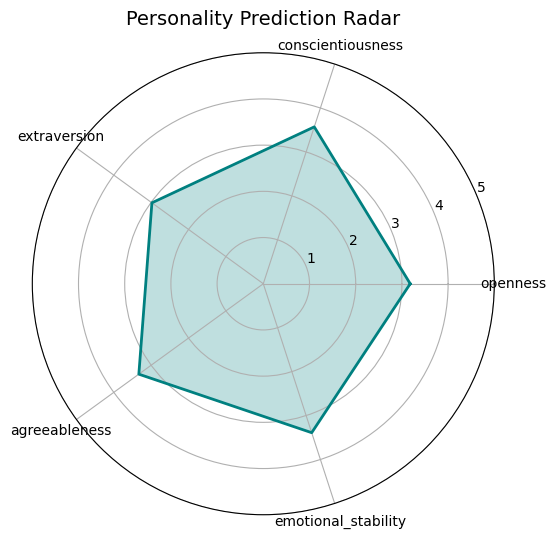

In [11]:
import matplotlib.pyplot as plt
import numpy as np

pred = predict_resume(sample_resume)

# Radar chart setup
traits = list(pred.keys())
scores = list(pred.values())
angles = np.linspace(0, 2*np.pi, len(traits), endpoint=False).tolist()
scores += scores[:1]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))
ax.plot(angles, scores, color='teal', linewidth=2)
ax.fill(angles, scores, color='teal', alpha=0.25)
ax.set_yticks([1,2,3,4,5])
ax.set_ylim(0,5)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(traits)
ax.set_title("Personality Prediction Radar", fontsize=14, pad=20)
plt.show()


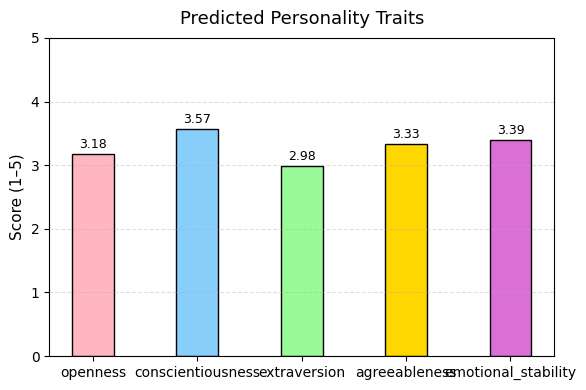

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Example: use your existing prediction
pred = predict_resume(sample_resume)

traits = list(pred.keys())
scores = list(pred.values())

# Softer colors for each bar
colors = ['#FFB6C1', '#87CEFA', '#98FB98', '#FFD700', '#DA70D6']

plt.figure(figsize=(6,4))  # smaller figure
bars = plt.bar(traits, scores, color=colors, width=0.4, edgecolor='black')

plt.title("Predicted Personality Traits", fontsize=13, pad=10)
plt.ylabel("Score (1–5)", fontsize=11)
plt.ylim(0,5)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Add small value labels above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f"{yval:.2f}",
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# y_test and y_pred_dict must exist from your previous code
# Example structure: y_pred_dict = {'openness': preds1, 'conscientiousness': preds2, ...}

metrics = {}

trait_names = ["openness","conscientiousness","extraversion","agreeableness","emotional_stability"]

for i, trait in enumerate(trait_names):
    # Use the index 'i' to access the correct column in the numpy array y_test
    y_true = y_test[:, i]
    y_pred = models[trait].predict(X_test)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    metrics[trait] = {'MAE': mae, 'RMSE': rmse, 'R²': r2}

# Convert to DataFrame for a clean display
metrics_df = pd.DataFrame(metrics).T
print("\n📊 Performance Metrics (Test Set):\n")
print(metrics_df.round(3))


📊 Performance Metrics (Test Set):

                       MAE   RMSE     R²
openness             0.443  0.546  0.440
conscientiousness    0.479  0.570  0.132
extraversion         0.721  0.901  0.071
agreeableness        0.393  0.512  0.200
emotional_stability  0.431  0.535 -0.045
